# SVM CLASSIFICATION WITH INDIVIDUAL REPLICAS AND ALL GENES

Training data
1. Uses individual replicas (not averaged)
1. Uses all genes
1. Includes time T1 (normoxia is not combined with resuscitation)

Issues
1. Poor feature selection yields poor classification accuracies; close to random
1. Related to (1), need to choose features by class.

# Preliminaries

## Imports

In [1]:
import init
from common import constants as cn
from common.trinary_data import TrinaryData
from common.data_provider import DataProvider
from common import transform_data
from common_python.plots import util_plots
from common_python.classifier import classifier_ensemble
from common_python.classifier import classifier_collection
from common import transform_data
from common_python.util import util
from common_python.classifier import feature_analyzer

import collections
import copy
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from sklearn.decomposition import PCA
from sklearn import svm
from sklearn.model_selection import cross_val_score

%matplotlib inline

## Constants

In [2]:
REPO_PATH = util.findRepositoryRoot("xstate")
NOTEBOOK_PATH = os.path.join(REPO_PATH, "notebooks")
DATA_PATH = os.path.join(REPO_PATH, "data")
SORT = "sort"
VALUE = "value"
max_var_replication = 1.5
SVM_ENSEMBLE = classifier_ensemble.ClassifierEnsemble(
        classifier_ensemble.ClassifierDescriptorSVM(),
        filter_high_rank=50,
        size=100, holdouts=1)
IS_RERUN = True

In [3]:
# "Short" data, with averaged replications
TRINARY_SHORT = TrinaryData(is_averaged=True, is_dropT1=True, is_regulator=False)  # Trinary data
DF_X_SHORT = TRINARY_SHORT.df_X
DF_X_SHORT = transform_data.removeGenesWithExcessiveReplicationVariance(DF_X_SHORT,
                                                                        max_var=max_var_replication)
SER_Y_SHORT = TRINARY_SHORT.ser_y
STATES_SHORT = SER_Y_SHORT.unique()

In [4]:
# "Long" data, with replications
TRINARY_LONG = TrinaryData(is_averaged=False, is_dropT1=False, is_regulator=False)  # Trinary data
DF_X_LONG = TRINARY_LONG.df_X
DF_X_LONG = transform_data.removeGenesWithExcessiveReplicationVariance(DF_X_LONG,
                                                                        max_var=max_var_replication)
SER_Y_LONG = TRINARY_LONG.ser_y
STATES_LONG = SER_Y_LONG.unique()

In [5]:
# Feature analyzers
ANALYZER_PATH_LONG = os.path.join(DATA_PATH, "feature_analyzer_with_replicas")
ANALYZER_PATH_PAT_LONG = os.path.join(ANALYZER_PATH_LONG, "%d") 
ANALYZER_LONG_DCT = feature_analyzer.deserialize({s: ANALYZER_PATH_PAT_LONG % s for s in STATES_LONG})

In [6]:
FITTED_SVM_PATH_SHORT = os.path.join(NOTEBOOK_PATH, "svm_classification_averaged.pcl")
try:
    if IS_RERUN:
        raise(Exception)
    FITTED_SVM_ENSEMBLE_SHORT.deserialize(FITTED_SVM_PATH_SHORT)
except:
    FITTED_SVM_ENSEMBLE_SHORT = copy.deepcopy(SVM_ENSEMBLE)
    FITTED_SVM_ENSEMBLE_SHORT.fit(DF_X_SHORT, SER_Y_SHORT)
    FITTED_SVM_ENSEMBLE_SHORT.serialize(FITTED_SVM_PATH_SHORT)

In [7]:
FITTED_SVM_PATH_LONG = os.path.join(NOTEBOOK_PATH, "svm_classification_individual.pcl")
try:
    if IS_RERUN:
        raise(Exception)
    FITTED_SVM_ENSEMBLE_LONG.deserialize(FITTED_SVM_PATH_LONG)
except:
    FITTED_SVM_ENSEMBLE_LONG = copy.deepcopy(SVM_ENSEMBLE)
    FITTED_SVM_ENSEMBLE_LONG.fit(DF_X_LONG, SER_Y_LONG)
    FITTED_SVM_ENSEMBLE_LONG.serialize(FITTED_SVM_PATH_LONG)

## Data
Data used in the analysis.

In [8]:
df_sampleAM = transform_data.trinaryReadsDF(
    csv_file="AM_MDM_Mtb_transcripts_DEseq.csv", is_time_columns=False, is_display_errors=False)
df_sampleAW = transform_data.trinaryReadsDF(csv_file="AW_plus_v_AW_neg_Mtb_transcripts_DEseq.csv",
                                            is_time_columns=False, is_display_errors=False)

In [9]:
df_sampleAM = df_sampleAM.T
df_sampleAW.columns

Index(['AW_plus_1', 'AW_neg_1', 'AW_plus_3', 'AW_neg_3', 'AW_plus_4',
       'AW_neg_4'],
      dtype='object')

In [10]:
df_sampleAW = df_sampleAW.T
df_sampleAW.head()

GENE_ID,Rv0001,Rv0005,Rv0006,Rv0009,Rv0010c,Rv0011c,Rv0013,Rv0014c,Rv0016c,Rv0020c,...,Rvnt36,Rvnt37,Rvnt38,Rvnt39,Rvnt40,Rvnt41,Rvnt42,Rvnt43,Rvnt44,Rvnt45
AW_plus_1,0,0,0,0,-1,0,-1,0,0,0,...,0,0,-1,0,-1,0,-1,0,0,-1
AW_neg_1,1,1,0,0,-1,1,-1,0,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
AW_plus_3,0,0,0,0,-1,1,0,0,0,0,...,0,0,-1,0,-1,-1,-1,-1,-1,-1
AW_neg_3,1,0,0,0,-1,1,0,0,0,0,...,0,-1,-1,-1,-1,-1,-1,-1,-1,-1
AW_plus_4,0,0,0,0,-1,1,0,0,0,0,...,0,0,-1,-1,-1,-1,-1,-1,-1,1


## Helpers

In [11]:
# Describes how feature importances are calculated for the construction of ensembles
# Importances should be calculated using analyzers. Must get state information.
class ClassifierDescriptorSVMAnalyzer(classifier_ensemble.ClassifierDescriptor):
    """ 
    Descriptor information needed for SVM classifiers
    Descriptor is for one-vs-rest. So, there is a separate
    classifier for each class.
    """
  
    def __init__(self, analyzer_dct, min_sfa_accuracy=0.8):
        """
        :params dict(key: object, value: FeatureAnalyzer):
        """
        self.analyzer_dct = analyzer_dct
        self.clf = svm.LinearSVC()  # Template classifier used to construct ensemble
        self.min_sfa_accuracy = min_sfa_accuracy

    def getImportance(self, clf, class_selection=None):
        """ 
        Calculates the importances of features.
        :param Classifier clf: fitted classifier
        :param obj class_selection: key in self.analyzer_dct
        :return list-float:
        """
        max_features = 100
        if class_selection is None:
            classes = list(self.analyzer_dct.keys())
        else:
            classes = class_selection
        # Order the features based on: (a) single factor predication accuracy (SFA) and (b) incremental
        # prediction accuracy beyond the previously chosen features
        value_dct = {}
        for key, analyzer in self.analyzer_dct.items():
            df_X = analyzer.df_X
            value_dct[key] = [analyzer.ser_sfa.loc[f] for f in df_X.columns]
            df = pd.DataFrame({VALUE: value_dct[key]})
            df[SORT] = range(len(df))
            df.index = df_X.columns
            # Adjust importance based on other features
            df = df.sort_values(VALUE, ascending = False)
            indices = list(df.index)
            # Importance is its maximum increase in classification accuracy
            for pos, idx in enumerate(indices[1:max_features]):
                priors = indices[0:pos+1]
                sub_priors = set(priors).intersection(analyzer.df_ipa.columns)
                if idx in analyzer.df_ipa.index:
                    try:
                        values = [analyzer.df_ipa.loc[idx, p] for p in sub_priors]
                    except Exception:
                        import pdb; pdb.set_trace()
                    df.loc[idx, VALUE] = np.max(values)
            df = df.sort_values(SORT)
            value_dct[key] = df[VALUE].values           
        # Calculate average values
        df = pd.DataFrame(value_dct)
        df = df.T
        df = df.applymap(lambda v: np.nan if v < self.min_sfa_accuracy else v)
        ser = df.mean(skipna=True)
        return ser.values
    
# TESTING
# FIXME: Lost Rv1813c
desc = ClassifierDescriptorSVMAnalyzer({0: ANALYZER_LONG_DCT[1]})
values = desc.getImportance(None)
assert(np.nanmax(values) > 0.9)

# Classification Validations of Controlled Samples
Classify T1-T25 and see if result is same as original class. Use 5-fold cross validation, where there is a holdout for each class and the selection is random.


In [12]:
IS_VALIDATIONS = True

In [13]:
# Analyze accuracy for class 1
if False:
    accuracy_dct = {}
    CLASS = 1
    data = copy.deepcopy(DATA)
    data.ser_y = DATA.ser_y.apply(lambda v: 1 if v == CLASS else 0)
    other_analyzers = [ANALYZER_DCT[o] for o in ANALYZER_DCT.keys() if o != CLASS]
    merged_analyzer = other_analyzers[0].copy()
    [merged_analyzer.merge(a) for a in other_analyzers[1:]]
    analyzer_dct = {CLASS: ANALYZER_DCT[CLASS], 0: merged_analyzer}
    analyzer_dct = {CLASS: ANALYZER_DCT[CLASS]}

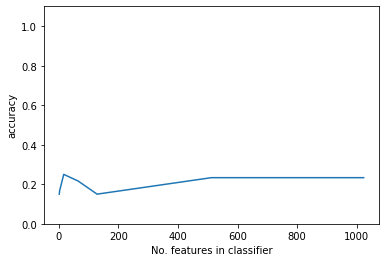

In [14]:
# With merging the other analyzers for the other class
# analyzer_dct[0] = merged_analyzer
if IS_VALIDATIONS:
    data = copy.deepcopy(TRINARY_LONG)
    data.df_X = DF_X_LONG
    data.ser_y = SER_Y_LONG
    accuracy_dct = {}
    for rank in [1, 2, 16, 64, 128, 512, 1024]:
        accuracy_dct[rank] = classifier_ensemble.ClassifierEnsemble.crossValidate(
            data, 
            #clf_desc=ClassifierDescriptorSVMAnalyzer(ANALYZER_DCT),
            num_iter=10, num_holdout=1, filter_high_rank=rank)
    plt.plot(list(accuracy_dct.keys()), list(accuracy_dct.values()))
    plt.ylim([0, 1.1])
    _ = plt.xlabel("No. features in classifier")
    _ = plt.ylabel("accuracy")

In [15]:
# Without merging
# analyzer_dct[0] = merged_analyzer
if False:
    for rank in [1, 2, 4, 8, 16, 32]:
        accuracy_dct[rank] = classifier_ensemble.ClassifierEnsemble.crossValidate(
            data, 
            clf_desc=ClassifierDescriptorSVMAnalyzer(analyzer_dct),
            num_iter=10, num_holdout=1, filter_high_rank=rank)
    plt.plot(list(accuracy_dct.keys()), list(accuracy_dct.values()))
    plt.ylim([0, 1.1])
    _ = plt.xlabel("No classifiers in ensemble")
    _ = plt.ylabel("accuracy")

# Investigation of Poor Classifier Performance

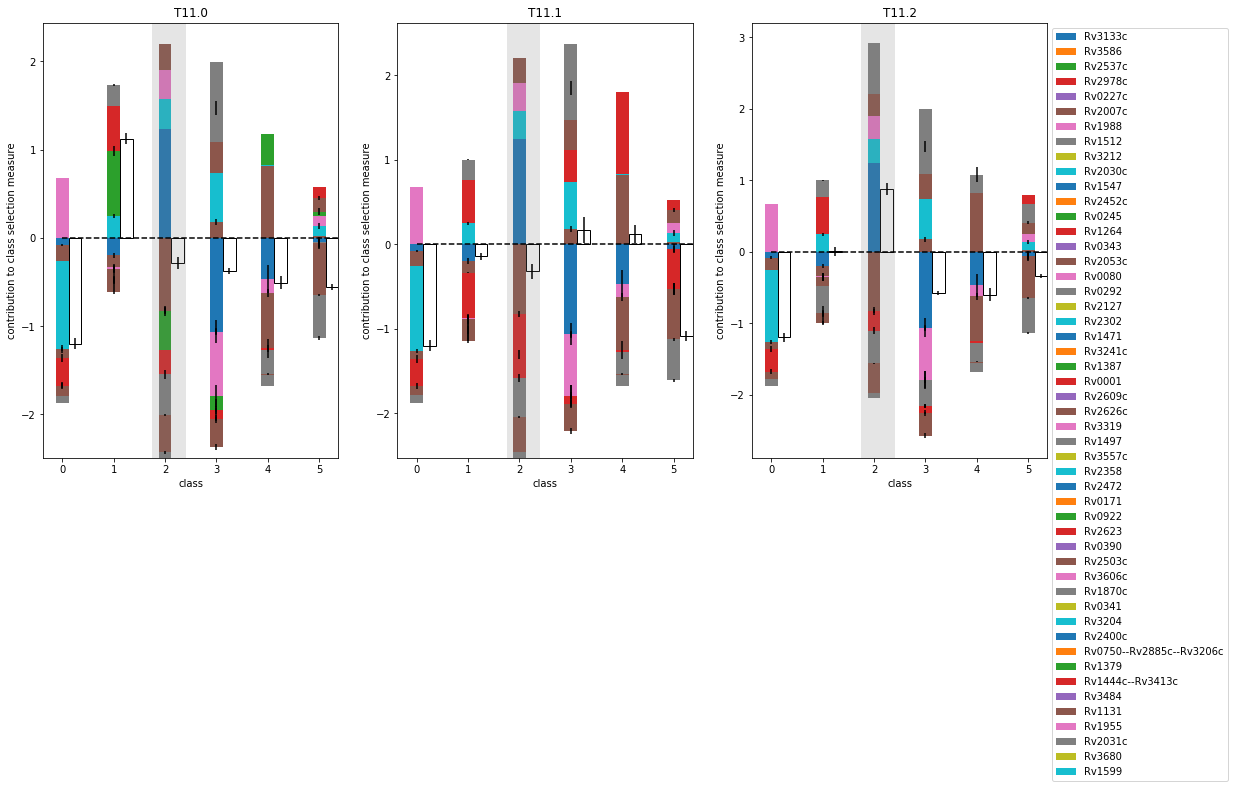

In [16]:
time = "T11"
_, axes = plt.subplots(1, 3, figsize=(18,8))
for idx, ax in enumerate(axes):
    instance = "%s.%d" % (time, idx)
    ser_X = DF_X_LONG.loc[instance, :]
    if idx == len(axes) - 1:
        is_legend = True
    else:
        is_legend = False
    FITTED_SVM_ENSEMBLE_LONG.plotFeatureContributions(ser_X, ax=ax,
            title=instance, true_class=SER_Y_LONG.loc[instance], is_plot=False, is_legend=is_legend)
plt.show()


## Variability of expression levels between replications

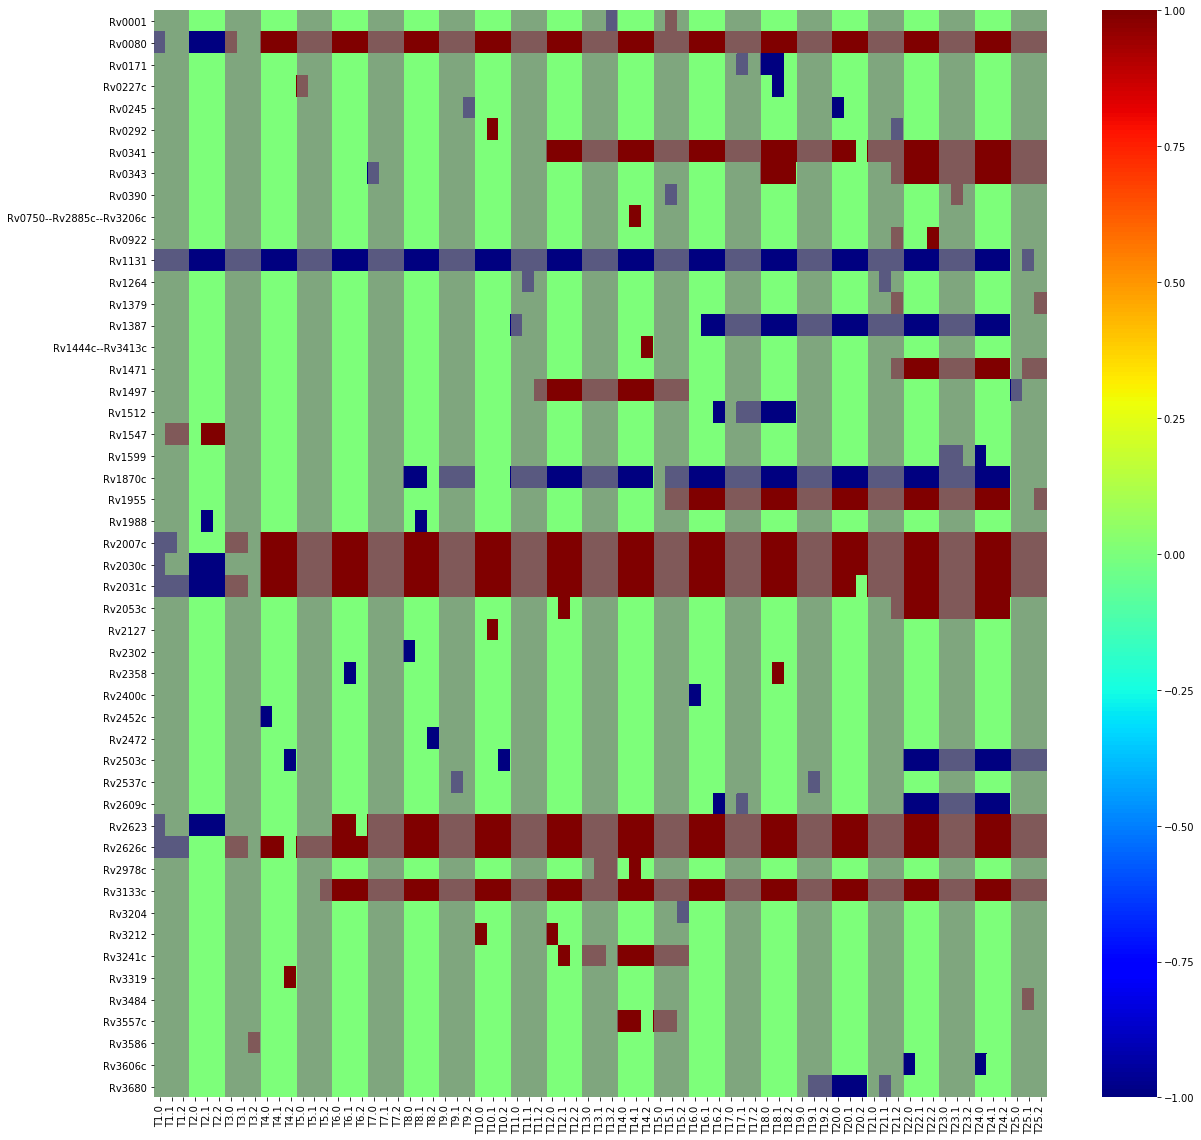

In [22]:
# Shade replications
fig, ax = plt.subplots(1, figsize=(20, 20))
columns = list(FITTED_SVM_ENSEMBLE_LONG.columns)
columns.sort()
indices = list(DF_X_LONG.index)
indices = sorted(indices, key=lambda v: float(v[1:]))
df_X = DF_X_LONG[columns]
df_X = df_X.loc[indices, :]
sns.heatmap(df_X.T, cmap="jet", ax=ax)
for idx in range(25):
    if idx % 2 == 0:
        plt.axvspan(3*idx, 3+3*idx, facecolor='grey', alpha=0.7)

Only use features that have low variability within replications.
Let $y_{itr}$ be the expression value for gene $i$, at time $t$, and replication $r$.
Sort genes $i$ by ascending value of $v_i = \sum_t var(y_{itr})$.

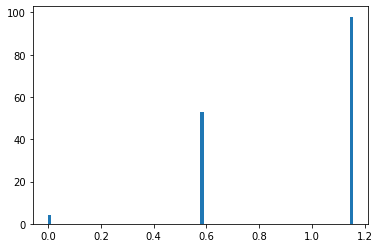

In [18]:
columns = list(FITTED_SVM_ENSEMBLE_LONG.columns)
df = DF_X_LONG.copy()
#df = df[columns]
df.index = [i[0:-2] for i in DF_X_LONG.index]
df = df.sort_index()
ser = df.groupby(df.index).std().sum()
_ = plt.hist(ser.sort_values(), bins=100)

# Classification of Lab Samples

In [19]:
svm_ensemble = classifier_ensemble.ClassifierEnsemble(
        classifier_ensemble.ClassifierDescriptorSVM(), filter_high_rank=15, size=30)
df_X = DF_X_LONG.copy()
svm_ensemble.fit(DF_X_LONG, SER_Y_LONG)

In [20]:
svm_ensemble.predict(df_sampleAM)

,0,1,2,3,4,5
AM_D20_1,0.0,0.0,0.000000,1.000000,0.0,0.000000
AM_D20_3,0.0,0.0,0.000000,0.000000,1.0,0.000000
AM_D20_4,0.0,0.0,0.000000,0.966667,0.0,0.033333
AM_D20_5,0.0,0.0,1.000000,0.000000,0.0,0.000000
MDM_D20_1,0.0,0.0,1.000000,0.000000,0.0,0.000000
MDM_D20_3,0.0,0.0,1.000000,0.000000,0.0,0.000000
MDM_D20_4,0.0,0.0,0.033333,0.966667,0.0,0.000000
MDM_D20_5,0.0,0.0,0.033333,0.966667,0.0,0.000000


In [21]:
svm_ensemble.predict(df_sampleAW)

,0,1,2,3,4,5
AW_plus_1,0.0,0.0,0.000000,1.000000,0.0,0.0
AW_neg_1,0.0,0.0,0.000000,1.000000,0.0,0.0
AW_plus_3,0.0,0.0,0.000000,0.900000,0.1,0.0
AW_neg_3,0.0,0.0,0.033333,0.966667,0.0,0.0
AW_plus_4,0.0,0.0,0.933333,0.066667,0.0,0.0
AW_neg_4,0.0,0.0,0.000000,1.000000,0.0,0.0
